In [1]:
import torch

import numpy as np

from pdes.models import LandauCahnHilliard, FloryHugginsCahnHilliard

from pdes.util import safe_cast, scattering

from torchdiffeq import odeint_adjoint as odeint

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use("ggplot")

In [2]:
class Evaluator(torch.nn.Module):
    def __init__(self, pde):
        super(Evaluator, self).__init__()
        self._pde  = pde
        
    def forward(self, x0, ts, dx = 1.):
        sim_phis = odeint(self._pde, x0, ts, method='euler')
        
        t_, phis_ = ts[99::900], sim_phis[99::900, :, 0, ...]
        Ss = []
        for i in range(len(t_)):
            if i > 0:
                S_ = scattering(phis_[i,...], dx)
            else:
                q, S_ = scattering(phis_[i,...], dx, True)
            Ss.append(S_)
        
        return phis_[-1,...], (q, Ss)

In [3]:
def plot_result(phi0, phiT, qSs):
    _, axs = plt.subplots(1,2, figsize=(14, 6))
    axs[0].contourf(phi0[0,0,...].detach().numpy(), cmap='Greys')
    axs[0].set_aspect('equal')
    axs[1].contourf(phiT[0,...].detach().numpy(), cmap='Greys')
    axs[1].set_aspect('equal')
    
    q, Ss = qSs
    plt.figure(figsize=(14, 6))
    plt.yscale('log')
    for i in range(len(Ss)):
        plt.plot(q, Ss[i][0,...].detach().numpy(), '-')

In [4]:
def default_params():
    return {
        'N'  : torch.tensor(1e5,     dtype=torch.float), # N*nu
      #  'nu' : torch.tensor(1e2,     dtype=torch.float),
        'chi': torch.tensor(0.25e-4, dtype=torch.float), # chi/nu
        'k'  : torch.tensor(7e-1,    dtype=torch.float)
    }

##### default parameters simuluation 

In [22]:
# theta = default_params()
theta = {'N': torch.tensor([136343.38], dtype=torch.float), 'chi': torch.tensor([2.3200106e-5], dtype=torch.float), 'k': torch.tensor([0.7067449],dtype=torch.float)}
dx, dt = 5e2, 1e8

pde = FloryHugginsCahnHilliard(params=theta, M = dt, dx = dx)

simulate = Evaluator(pde)

In [23]:
NX, ts = 256, torch.arange(1e4)

phi0 = 0.5 + (0.2 * torch.rand((NX, NX))).view(-1, 1, NX, NX)

phiT, qSs = simulate(phi0, ts, dx)

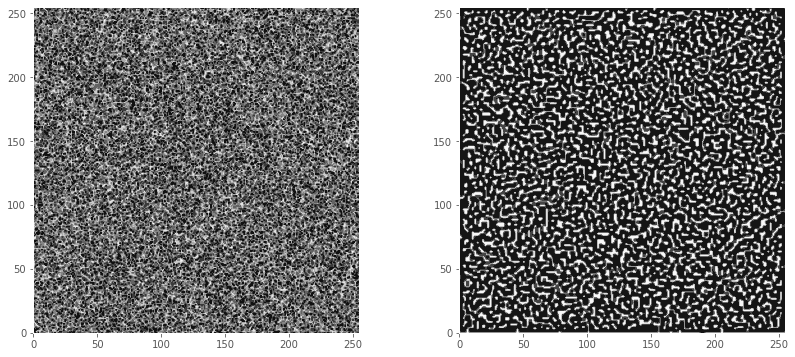

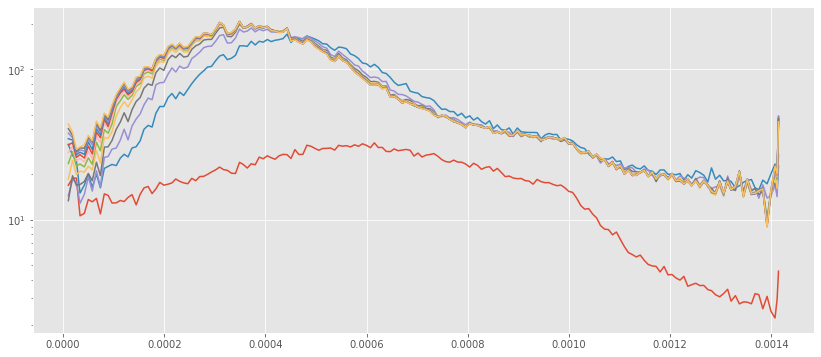

In [24]:
plot_result(phi0,phiT,qSs)

In [18]:
np.any(np.isnan(qSs[1][0].detach().numpy()))

False

### guess priors

In [8]:
def proposed_priors():
    return {
        'N'  : torch.tensor([5e4, 1e5, 1.5e5], dtype=torch.float), # 2. reduce upper limit by half
       # 'nu' : torch.tensor([5e0, 5e1, 5e2], dtype=torch.float),
        'chi': torch.tensor([2e-5, 2.5e-5, 2.9e-5], dtype=torch.float), # 1. changed upper limit [down x3]
        'k'  : torch.tensor([6.832446e-1, 7e-1, 7.2680455e-1],    dtype=torch.float)
    }

In [9]:
priors = proposed_priors()

thetas = []
for i in range(3):
    for j in range(3):
        for k in range(1,2):
            thetas.append({n: priors[n][v] for n,v in zip(['N','chi','k'],[i,j,k])})

{'N': tensor(50000.), 'chi': tensor(2.0000e-05), 'k': tensor(0.7000)}


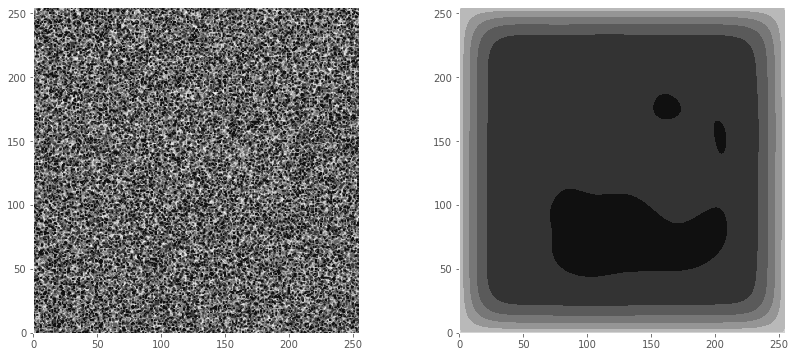

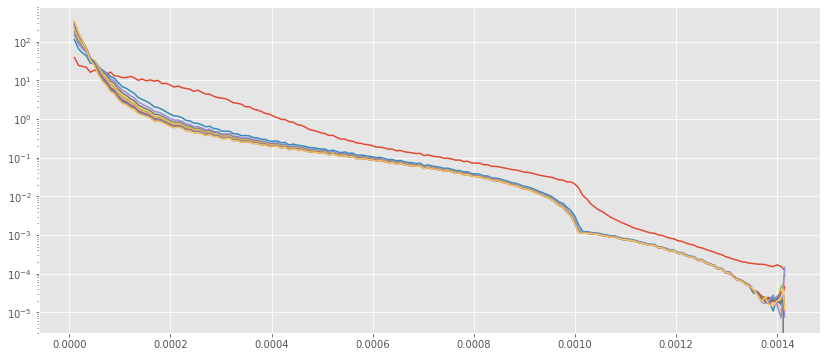

{'N': tensor(50000.), 'chi': tensor(2.5000e-05), 'k': tensor(0.7000)}


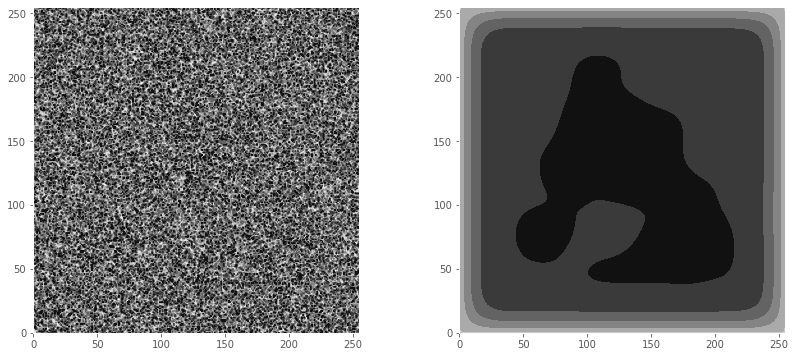

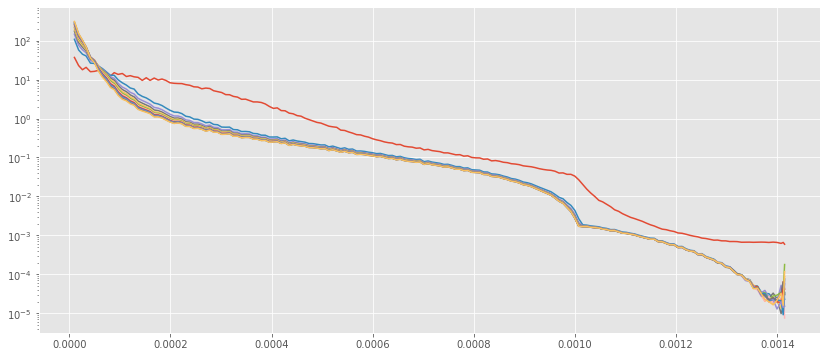

{'N': tensor(50000.), 'chi': tensor(2.9000e-05), 'k': tensor(0.7000)}


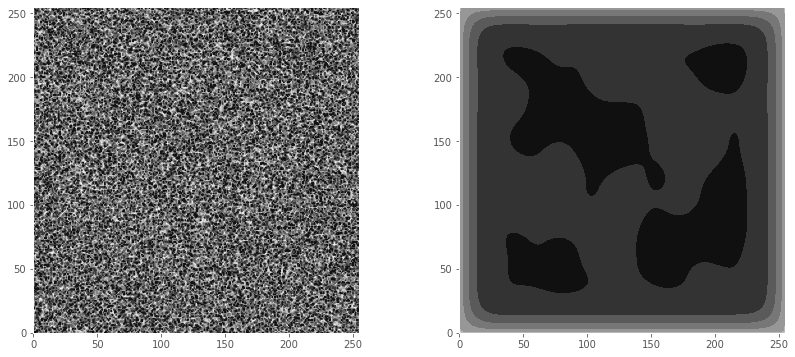

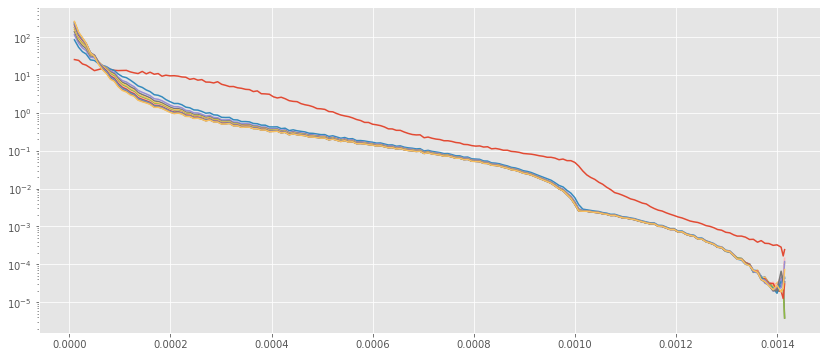

{'N': tensor(100000.), 'chi': tensor(2.0000e-05), 'k': tensor(0.7000)}


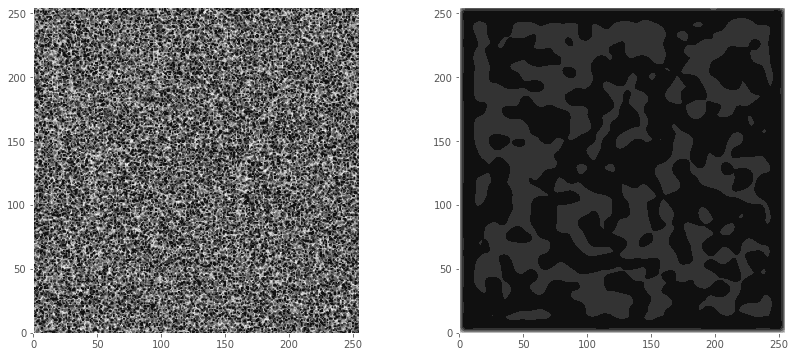

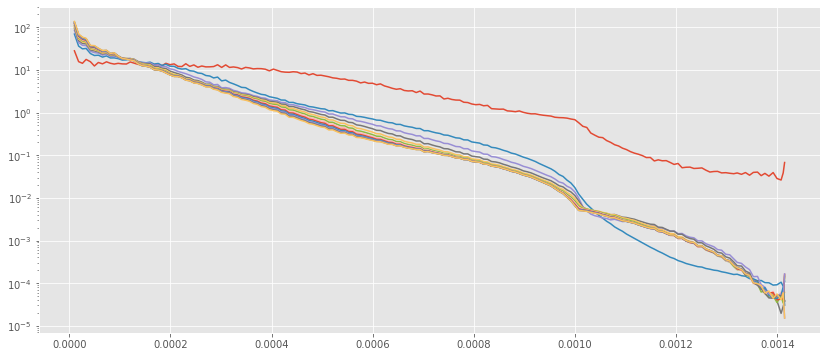

{'N': tensor(100000.), 'chi': tensor(2.5000e-05), 'k': tensor(0.7000)}


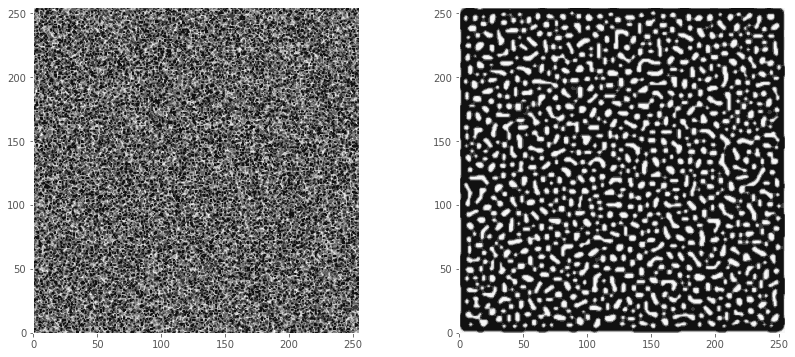

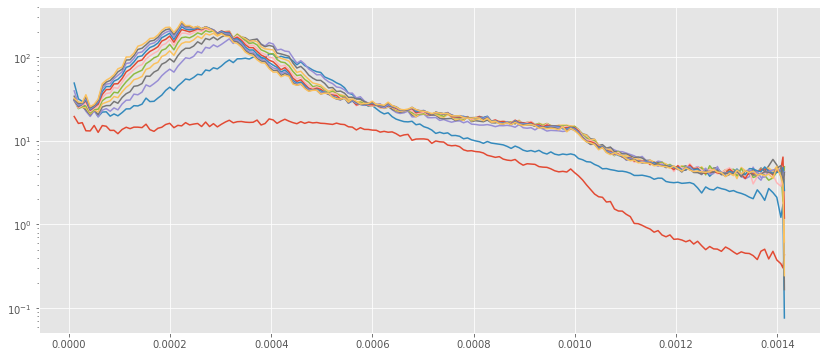

{'N': tensor(100000.), 'chi': tensor(2.9000e-05), 'k': tensor(0.7000)}


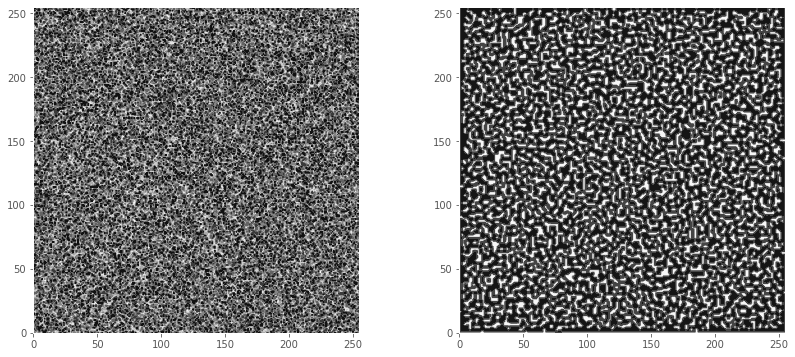

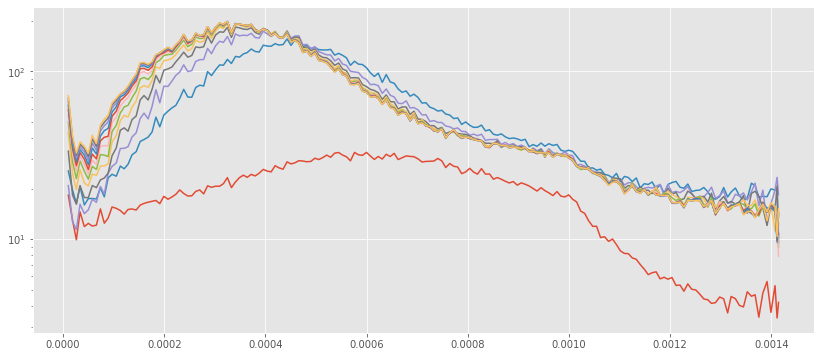

{'N': tensor(150000.), 'chi': tensor(2.0000e-05), 'k': tensor(0.7000)}


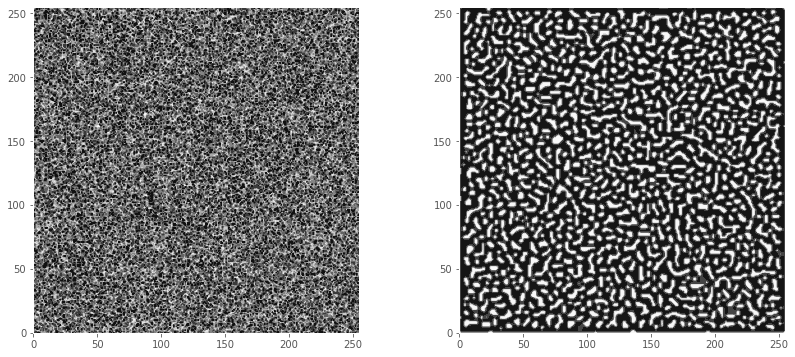

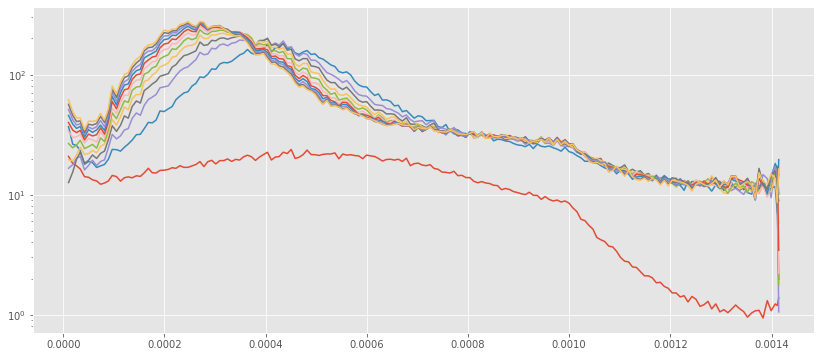

{'N': tensor(150000.), 'chi': tensor(2.5000e-05), 'k': tensor(0.7000)}


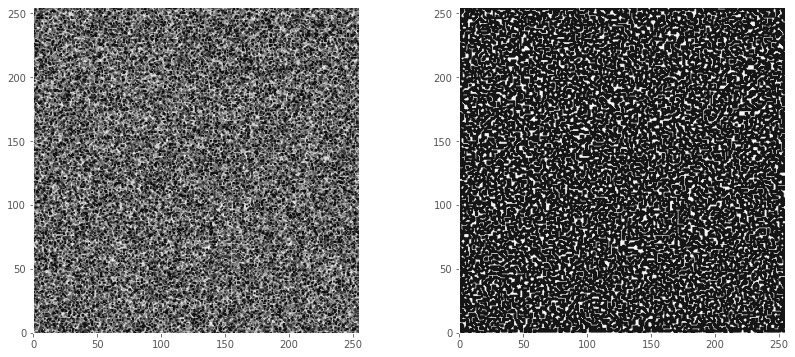

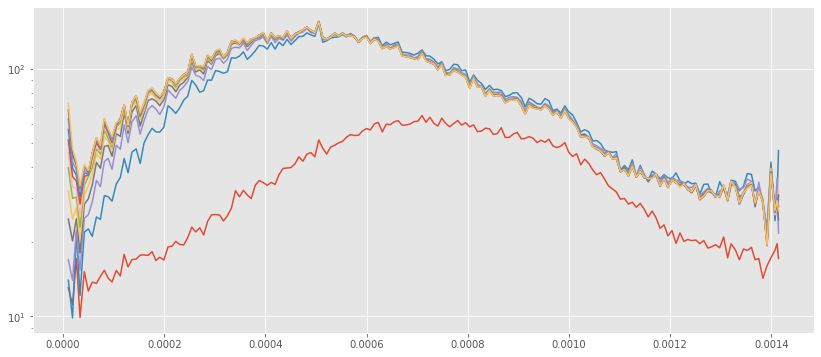

{'N': tensor(150000.), 'chi': tensor(2.9000e-05), 'k': tensor(0.7000)}


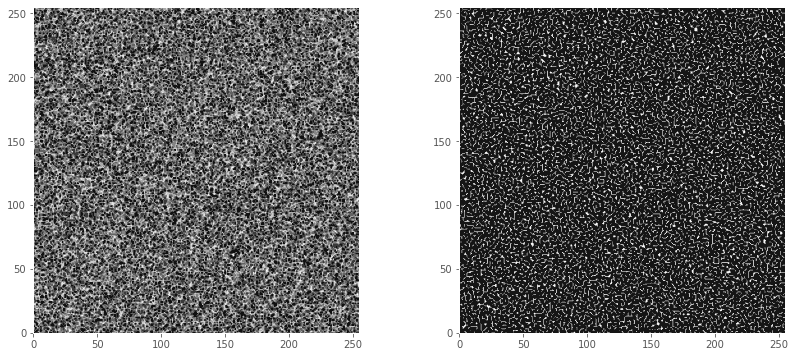

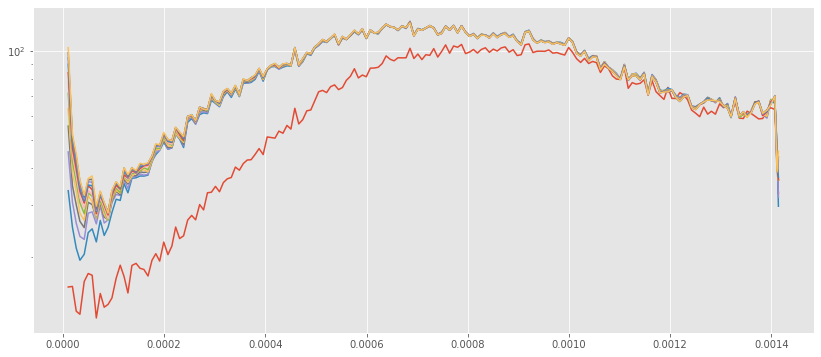

In [10]:
for theta in thetas:
    pde = FloryHugginsCahnHilliard(params=theta, M = dt, dx = dx)

    simulate = Evaluator(pde)

    phi0 = 0.5 + (0.2 * torch.rand((NX, NX))).view(-1, 1, NX, NX)

    phiT, qSs = simulate(phi0, ts, dx)
    
    print(theta)
    plot_result(phi0,phiT,qSs)
    plt.show()